# Search for positioner collisions by reading PlateMaker files

## Startup

### Logging

Use the logger to help follow progress, and recort when cells are run.

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2021-09-24 12:47:41,176 Starting


### Imports

In [2]:
import os
import re
from functools import partial
from collections import namedtuple
import numbers
import glob
import getpass
import psycopg2
import h5py
import cycler
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy
from astropy.stats import biweight_midvariance
from scipy.constants import golden
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.stats import biweight_midvariance

In [3]:
import desimeter.transform
import desimeter.transform.pos2ptl as pos2ptl

In [4]:
%load_ext autoreload
%autoreload 1

The `motortest` code is in the same directory as this notebook, so should be visible.

In [5]:
%aimport poscoll

2021-09-24 12:47:43,057 Importing poscoll


### Configuration

If we do not have it already (e.g. because the notebook is being rerun), query for the DOS database password, echo dots instead of showing the password.

In [6]:
try:
    assert len(poscoll.DESI_DBPASSWORD)>0
except (AssertionError, NameError):
    print("Site database password: ", end="")
    poscoll.DESI_DBPASSWORD = getpass.getpass()

Site database password: 

 ······


Plotting:

In [7]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
mpl.rcParams["axes.prop_cycle"] = cycler.cycler(
    color=[
        "#004D99",
        "#8B2B2B",
        "#4C8C2C",
        "#E29F00",
        "#2700FF",
        "#9B00C2",
        "#40A500",
        "#827B82",
        "#00AA9E",
        "#9D6604",
        "#FB01D3",
        "#9ECC8E",
    ]
)

np.random.seed(6563)

In [8]:
os.getcwd()

'/global/u2/n/neilsen/devel/desi/fpoffline/nb/collision_search'

## Mapping `petal_id` to `petal_loc`

In [9]:
with open(poscoll.PETAL_NAME_MAP_FNAME) as fp:
    petal_name_map = pd.read_table(fp, delim_whitespace=True)
    
petal_name_map.rename(columns={'#PETAL_ID': 'petal_id', 'PETAL_LOC': 'petal_loc'}, inplace=True)
petal_name_map.set_index('petal_id', drop=False, inplace=True)
    
    
petal_name_map

,petal_id,petal_loc,GFA#,Type,Kent
petal_id,,,,,
4,4,0,10,G,9
5,5,1,5,W,10
6,6,2,6,G,11
3,3,3,2,G,2
8,8,4,7,W,3
10,10,5,8,G,4
11,11,6,13,W,5
2,2,7,1,G,6
7,7,8,4,G,7


## Get a list of nights with exposures

In [10]:
nights = poscoll.query_nights_with_exposures()
nights

,first_time,last_time,first_id,max_id,night_mjd,num_exposures
0,2019-01-01 00:00:00+00:00,2019-01-01 00:00:00+00:00,1,7,58484,5
1,2019-01-31 17:14:53.161756+00:00,2019-01-31 17:14:53.161756+00:00,8,8,58515,1
2,2019-02-04 20:24:45.285221+00:00,2019-02-05 07:24:16.158119+00:00,9,43,58519,32
3,2019-02-05 18:27:42.781990+00:00,2019-02-06 04:34:32.930685+00:00,47,52,58520,2
4,2019-02-06 21:07:20.883422+00:00,2019-02-06 21:07:20.883422+00:00,60,60,58521,1
...,...,...,...,...,...,...
619,2021-09-20 21:55:45.061340+00:00,2021-09-21 07:07:25.874457+00:00,100955,101074,59478,119
620,2021-09-21 07:28:32.001783+00:00,2021-09-22 07:18:49.973375+00:00,101075,101173,59479,91
621,2021-09-22 07:45:57.962159+00:00,2021-09-23 05:42:07.488740+00:00,101174,101333,59480,142
622,2021-09-23 11:24:00.383093+00:00,2021-09-24 07:15:54.811467+00:00,101336,101429,59481,90


## Get exposures on a night

In [11]:
night_expids = poscoll.query_night_exposures(59310)

In [12]:
night_expids = poscoll.query_night_exposures(59310)
len(night_expids)

132

## Find executions of `fvcproc` for an exposure

In [13]:
poscoll.find_exposure_fvcprocs(83714)

['/global/cfs/cdirs/desi/users/skent/data/desi/83714/positioner-corr-83714.12.dat',
 '/global/cfs/cdirs/desi/users/skent/data/desi/83714/positioner-corr-83714.18.dat']

# Read all nonfunctional positioners for a sample of nights to get normal variation

In [14]:
nights

,first_time,last_time,first_id,max_id,night_mjd,num_exposures
0,2019-01-01 00:00:00+00:00,2019-01-01 00:00:00+00:00,1,7,58484,5
1,2019-01-31 17:14:53.161756+00:00,2019-01-31 17:14:53.161756+00:00,8,8,58515,1
2,2019-02-04 20:24:45.285221+00:00,2019-02-05 07:24:16.158119+00:00,9,43,58519,32
3,2019-02-05 18:27:42.781990+00:00,2019-02-06 04:34:32.930685+00:00,47,52,58520,2
4,2019-02-06 21:07:20.883422+00:00,2019-02-06 21:07:20.883422+00:00,60,60,58521,1
...,...,...,...,...,...,...
619,2021-09-20 21:55:45.061340+00:00,2021-09-21 07:07:25.874457+00:00,100955,101074,59478,119
620,2021-09-21 07:28:32.001783+00:00,2021-09-22 07:18:49.973375+00:00,101075,101173,59479,91
621,2021-09-22 07:45:57.962159+00:00,2021-09-23 05:42:07.488740+00:00,101174,101333,59480,142
622,2021-09-23 11:24:00.383093+00:00,2021-09-24 07:15:54.811467+00:00,101336,101429,59481,90


In [15]:
nonfunc_pos_sample = poscoll.read_many_nights(nights, 20)

2021-09-24 12:47:53,034 No files for MJD 58804 had a FLAGS column
2021-09-24 12:48:11,115 Read 692358 positions, kept 153039 for MJD 59217 (2021-01-03)
2021-09-24 12:48:19,211 Read 89568 positions, kept 14220 for MJD 59381 (2021-06-16)
2021-09-24 12:48:29,764 Read 208675 positions, kept 32947 for MJD 59356 (2021-05-22)
2021-09-24 12:48:30,916 No files for MJD 58799 had a FLAGS column
2021-09-24 12:48:40,523 Read 174335 positions, kept 28665 for MJD 59213 (2020-12-30)
2021-09-24 12:48:40,780 No files for MJD 58823 had a FLAGS column
2021-09-24 12:48:48,867 Read 99360 positions, kept 10408 for MJD 59329 (2021-04-25)
2021-09-24 12:48:58,813 Read 227994 positions, kept 0 for MJD 58885 (2020-02-06)


In [16]:
nf_night_pos_stats = nonfunc_pos_sample.groupby(['petal_loc', 'device_loc'])['obs_diff'].describe().sort_values('max', ascending=False)
nf_night_pos_stats.head(10)

count      mean       std    min       25%       50%  \
petal_loc device_loc                                                         
8         258         249.0  0.016910  0.127103  0.000  0.004472  0.007071   
1         251         249.0  0.015981  0.117861  0.000  0.004472  0.007616   
3         423         249.0  0.016108  0.107476  0.001  0.005385  0.007810   
7         111         249.0  0.014246  0.094585  0.000  0.004243  0.007071   
6         519         249.0  0.016198  0.089884  0.000  0.005099  0.008944   
4         324         249.0  0.016162  0.089114  0.000  0.005099  0.009220   
          258         249.0  0.015959  0.087263  0.000  0.005385  0.009220   
7         508         249.0  0.015067  0.083424  0.000  0.005099  0.008062   
1         454         249.0  0.014409  0.079183  0.000  0.005000  0.008062   
8         437         249.0  0.014276  0.079023  0.001  0.005000  0.008062   

                           75%       max  
petal_loc device_loc                      
8         258         0.012166  2.012157  
1         251         0.011045  1.866304  
3         423         0.012530  1.702394  
7         111         0.011180  1.498415  
6         519         0.014318  1.424052  
4         324         0.014422  1.412353  
          258         0.013892  1.382382  
7         508         0.012649  1.321820  
1         454         0.012207  1.255395  
8         437         0.013000  1.252697

In [17]:
xvar, yvar = biweight_midvariance(nonfunc_pos_sample.obs_x_diff.dropna()), biweight_midvariance(nonfunc_pos_sample.obs_y_diff.dropna())
tot_sig = np.sqrt(xvar + yvar)
np.sqrt(xvar), np.sqrt(yvar), tot_sig

(0.007559695131190848, 0.006989678669549147, 0.010295853455644217)

# Read all moves on a night for positioners with at least one large move that night

In [18]:
%%time
fname = 'pm_positions_010.pickle'
try:
    logger.info(f"Trying to read {fname}") 
    positions = pd.read_pickle(fname)
    logger.info(f"Read {fname}")
except FileNotFoundError:
    logger.info(f"Could not read {fname}, creating from PM output")
    logger.info("This took about 30 minutes in the past")
    positions = poscoll.read_many_nights(move_thresh=0.1)
    logger.info(f"PlateMaker files read, writing to {fname}")
    positions.to_pickle(fname)
    logger.info(f"Wrote {fname}")

2021-09-24 12:49:04,028 Trying to read pm_positions_010.pickle
2021-09-24 12:49:04,041 Read pm_positions_010.pickle


CPU times: user 10.5 ms, sys: 4.06 ms, total: 14.5 ms
Wall time: 13.6 ms


In [19]:
positions

fname  \
night_mjd petal_loc device_loc expid  configid row                                   
59206     9         286        69590  17       3765   positioner-corr-69590.17.dat   
                               69591  11       3765   positioner-corr-69591.11.dat   
                                      17       3765   positioner-corr-69591.17.dat   
                               69592  11       3765   positioner-corr-69592.11.dat   
                                      17       3765   positioner-corr-69592.17.dat   
...                                                                            ...   
59478     6         488        101187 18       4950  positioner-corr-101187.18.dat   
                    502        101187 18       4958  positioner-corr-101187.18.dat   
                    505        101187 18       4961  positioner-corr-101187.18.dat   
                    510        101187 18       4966  positioner-corr-101187.18.dat   
                    519        101187 18       4970  positioner-corr-101187.18.dat   

                                                     fvc_id  delta_x  delta_y  \
night_mjd petal_loc device_loc expid  configid row                              
59206     9         286        69590  17       3765    9286   -0.039   -1.528   
                               69591  11       3765    9286   -0.030   -1.538   
                                      17       3765    9286   -0.022   -1.545   
                               69592  11       3765    9286   -0.035   -1.574   
                                      17       3765    9286   -0.038   -1.576   
...                                                     ...      ...      ...   
59478     6         488        101187 18       4950   11488    0.034   -0.036   
                    502        101187 18       4958   11502    0.014   -0.068   
                    505        101187 18       4961   11505   -0.007   -0.034   
                    510        101187 18       4966   11510    0.027   -0.039   
                    519        101187 18       4970   11519    0.038   -0.037   

                                                       obs_x    obs_y  \
night_mjd petal_loc device_loc expid  configid row                      
59206     9         286        69590  17       3765 -157.394 -244.753   
                               69591  11       3765 -157.424 -244.763   
                                      17       3765 -157.431 -244.756   
                               69592  11       3765 -157.440 -244.738   
                                      17       3765 -157.436 -244.737   
...                                                      ...      ...   
59478     6         488        101187 18       4950 -224.477  318.394   
                    502        101187 18       4958 -214.026  344.849   
                    505        101187 18       4961 -233.613  322.716   
                    510        101187 18       4966 -269.537  281.885   
                    519        101187 18       4970 -244.894  323.055   

                                                        flags  ctrl_disabled  \
night_mjd petal_loc device_loc expid  configid row                             
59206     9         286        69590  17       3765  16842821           True   
                               69591  11       3765  16842821           True   
                                      17       3765  16842821           True   
                               69592  11       3765  16842821           True   
                                      17       3765  16842821           True   
...                                                       ...            ...   
59478     6         488        101187 18       4950  16842757           True   
                    502        101187 18       4958  16842757           True   
                    505        101187 18       4961  16842757           True   
                    510        101187 18       4966  16842757           Tr

# Counting exposure/config instances with lots of big shifts

In [20]:
positions.query('obs_diff>0.1').groupby(['night', 'night_mjd', 'expid', 'configid'])['obs_diff'].count().loc[lambda n: n>2].sort_values(ascending=False)

night       night_mjd  expid   configid
2021-09-21  59478      101182  18          622
                       101183  12          618
2021-01-03  59217      70729   11          374
2021-01-30  59244      73732   11           13
                       73731   11            8
2021-04-02  59306      83157   11            5
2021-03-27  59300      82493   11            5
2021-04-02  59306      83158   11            5
2021-05-29  59363      90228   12            4
2021-03-27  59300      82495   11            4
2021-05-05  59339      87373   12            3
2021-05-04  59338      87256   12            3
                       87254   12            3
2021-04-06  59310      83729   12            3
                       83726   12            3
2021-04-04  59308      83422   12            3
2021-03-24  59297      81855   11            3
2021-03-22  59295      81532   11            3
Name: obs_diff, dtype: int64

According to `[desi-nightlog 255] Night Summary 20210103`, `expid=70728` was an autofocus initialization, which might explain the jump in many positioners. We should ignore these.

# Drop nights with big shifts of lots of positioners

In [21]:
bad_mjds = positions.query('obs_diff>0.1').groupby(['night', 'night_mjd', 'expid', 'configid'])['obs_diff'].count().loc[lambda n: n>5].sort_values(ascending=False).reset_index().night_mjd.values

In [22]:
good_mjds = np.setdiff1d(positions.index.get_level_values('night_mjd').unique(), bad_mjds)

In [23]:
positions = positions.loc[good_mjds].copy()
positions

fname  \
night_mjd petal_loc device_loc expid configid row                                  
59206     9         286        69590 17       3765  positioner-corr-69590.17.dat   
                               69591 11       3765  positioner-corr-69591.11.dat   
                                     17       3765  positioner-corr-69591.17.dat   
                               69592 11       3765  positioner-corr-69592.11.dat   
                                     17       3765  positioner-corr-69592.17.dat   
...                                                                          ...   
59404     9         253        98068 12       3732  positioner-corr-98068.12.dat   
                                     18       3731  positioner-corr-98068.18.dat   
59405     9         253        98271 18       3732  positioner-corr-98271.18.dat   
                               98272 12       3732  positioner-corr-98272.12.dat   
                                     18       3732  positioner-corr-98272.18.dat   

                                                    fvc_id  delta_x  delta_y  \
night_mjd petal_loc device_loc expid configid row                              
59206     9         286        69590 17       3765    9286   -0.039   -1.528   
                               69591 11       3765    9286   -0.030   -1.538   
                                     17       3765    9286   -0.022   -1.545   
                               69592 11       3765    9286   -0.035   -1.574   
                                     17       3765    9286   -0.038   -1.576   
...                                                    ...      ...      ...   
59404     9         253        98068 12       3732    9253    0.066    0.039   
                                     18       3731    9253    0.059    0.038   
59405     9         253        98271 18       3732    9253    0.085    0.057   
                               98272 12       3732    9253    0.087   -0.046   
                                     18       3732    9253    0.090   -0.045   

                                                      obs_x    obs_y  \
night_mjd petal_loc device_loc expid configid row                      
59206     9         286        69590 17       3765 -157.394 -244.753   
                               69591 11       3765 -157.424 -244.763   
                                     17       3765 -157.431 -244.756   
                               69592 11       3765 -157.440 -244.738   
                                     17       3765 -157.436 -244.737   
...                                                     ...      ...   
59404     9         253        98068 12       3732 -122.776 -242.584   
                                     18       3731 -122.770 -242.582   
59405     9         253        98271 18       3732 -122.796 -242.604   
                               98272 12       3732 -122.800 -242.496   
                                     18       3732 -122.802 -242.493   

                                                       flags  ctrl_disabled  \
night_mjd petal_loc device_loc expid configid row                             
59206     9         286        69590 17       3765  16842821           True   
                               69591 11       3765  16842821           True   
                                     17       3765  16842821           True   
                               69592 11       3765  16842821           True   
                                     17       3765  16842821           True   
...                                                      ...            ...   
59404     9         253        98068 12       3732  16842821           True   
                                     18       3731  16842757           True   
59405     9         253        98271 18       3732  16842757           True   
                               98272 12       3732  16842821           True   
                                     18       3732  1684

# Find frequently bad positioners, and drop them

In [24]:
bad_devices = positions.query('obs_diff>0.1').groupby(['petal_loc', 'device_loc'])['obs_diff'].count().loc[lambda n: n>20].sort_values(ascending=False).index
bad_devices

MultiIndex([(6, 505),
            (9, 253),
            (8, 488),
            (8, 451),
            (6, 510),
            (6,  45)],
           names=['petal_loc', 'device_loc'])

In [25]:
device_bad = pd.Series(False, index=positions.index, name='bad_device').reset_index().set_index(bad_devices.names)
device_bad.loc[bad_devices, 'bad_device'] = True
device_bad = device_bad.reset_index().set_index(positions.index.names)['bad_device']
device_bad

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


night_mjd  petal_loc  device_loc  expid  configid  row 
59206      9          286         69590  17        3765    False
                                  69591  11        3765    False
                                         17        3765    False
                                  69592  11        3765    False
                                         17        3765    False
                                                           ...  
59404      9          253         98068  12        3732     True
                                         18        3731     True
59405      9          253         98271  18        3732     True
                                  98272  12        3732     True
                                         18        3732     True
Name: bad_device, Length: 13278, dtype: bool

In [26]:
positions = positions.loc[~device_bad, :]

# Counting shifts by size

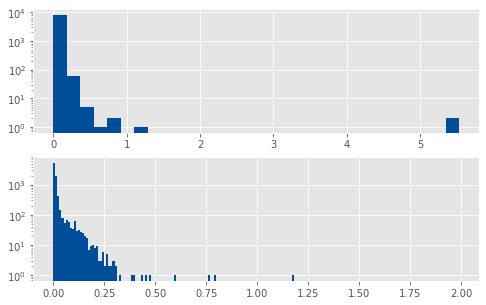

In [27]:
fig, axes = plt.subplots(2)
positions.obs_diff.hist(bins=30, ax=axes[0])
positions.obs_diff.hist(bins=np.arange(0, 2, 0.01), ax=axes[1])
for ax in axes:
    ax.set_yscale('log')

## Finding big shifts, and plot some

In [28]:
max_obs_diff = positions.groupby(['night_mjd', 'petal_loc', 'device_loc'])['obs_diff'].max().sort_values(ascending=False)
max_obs_diff

night_mjd  petal_loc  device_loc
59230      4          318           5.534079
59308      6          466           1.179943
59338      8          335           0.798223
59310      8          419           0.599001
59376      3          483           0.473033
                                      ...   
59363      9          286           0.101272
59219      9          370           0.101213
59300      9          254           0.101020
59206      9          286           0.100955
59306      1          341           0.100245
Name: obs_diff, Length: 170, dtype: float64

/global/u2/n/neilsen/devel/desi/fpoffline/nb/collision_search/poscoll.py:444: PerformanceWarning: indexing past lexsort depth may impact performance.
  positions.loc[(night_mjd, petal_loc, device_loc)].sort_index().copy()
/global/u2/n/neilsen/devel/desi/fpoffline/nb/collision_search/poscoll.py:444: PerformanceWarning: indexing past lexsort depth may impact performance.
  positions.loc[(night_mjd, petal_loc, device_loc)].sort_index().copy()
/global/u2/n/neilsen/devel/desi/fpoffline/nb/collision_search/poscoll.py:444: PerformanceWarning: indexing past lexsort depth may impact performance.
  positions.loc[(night_mjd, petal_loc, device_loc)].sort_index().copy()


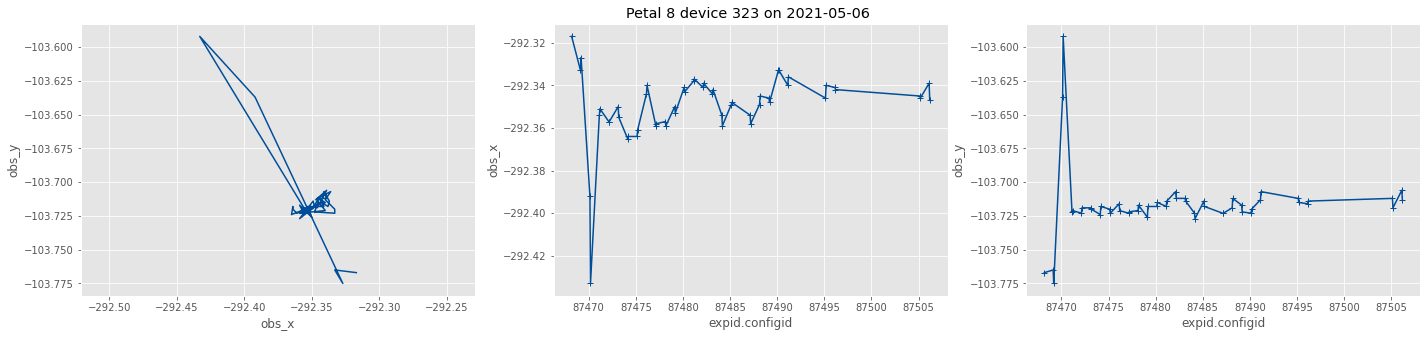

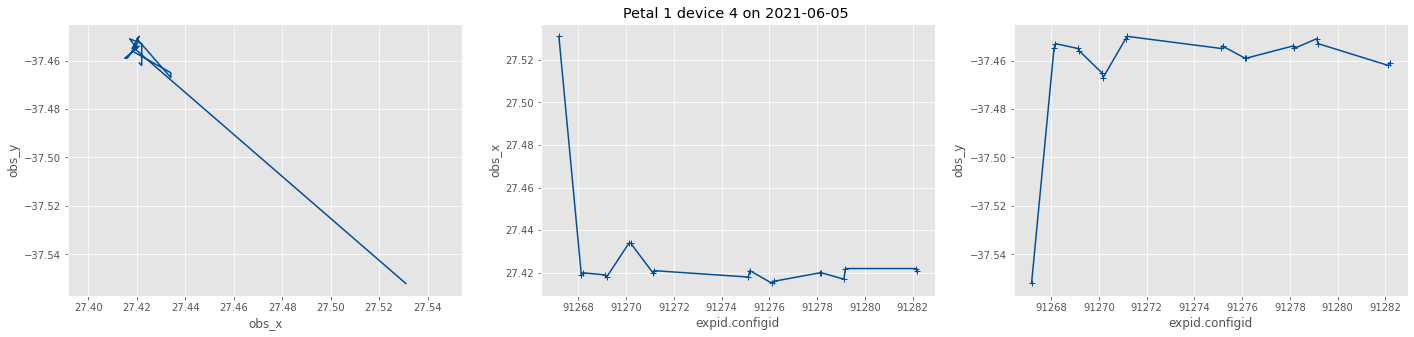

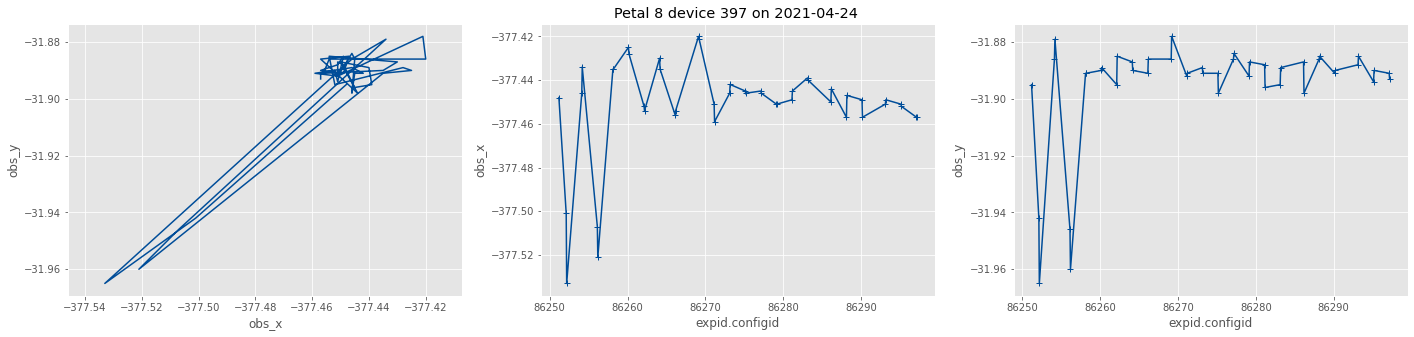

In [29]:
for (night_mjd, petal_loc, device_loc), this_max_diff in max_obs_diff.sample(3, random_state=100).iteritems():
    fig, axes = poscoll.plot_pos(night_mjd, petal_loc, device_loc, positions)

59383.0, 7, 50
59316.0, 4, 400
59294.0, 5, 203
59338.0, 8, 397
59375.0, 1, 288
59300.0, 5, 62
59308.0, 5, 106
59300.0, 8, 215
59300.0, 3, 177
59385.0, 8, 156
59342.0, 1, 4
59308.0, 7, 273
59338.0, 8, 317
59338.0, 8, 132
59370.0, 1, 4
59306.0, 7, 50
59306.0, 2, 366
59306.0, 2, 437
59297.0, 1, 288
59297.0, 3, 212


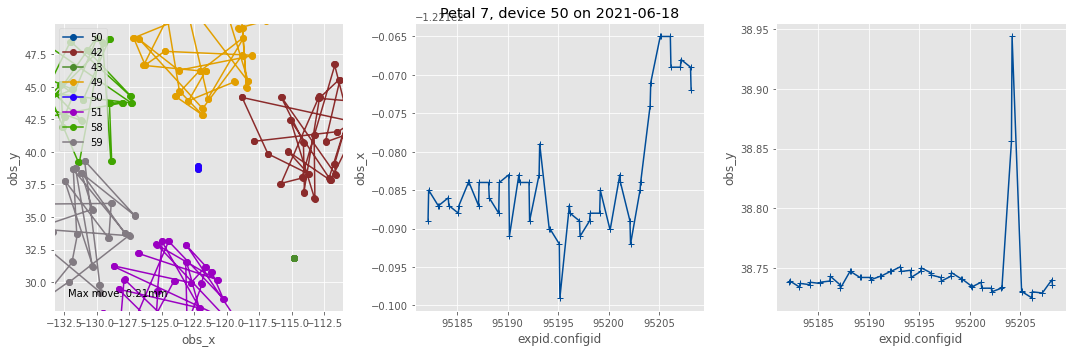

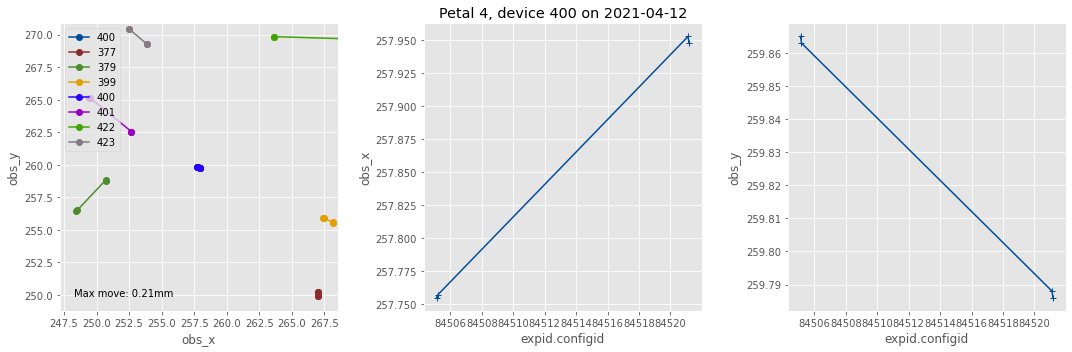

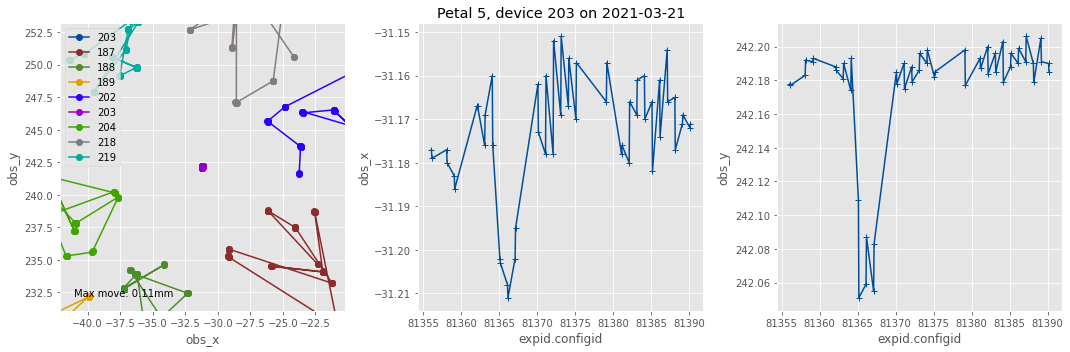

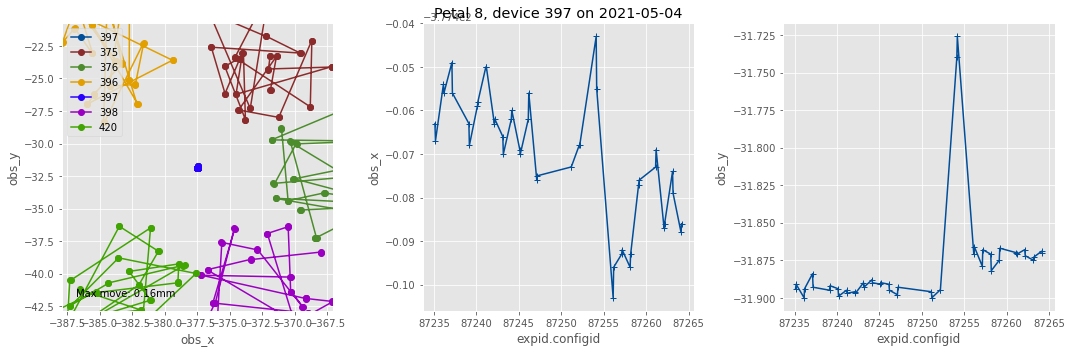

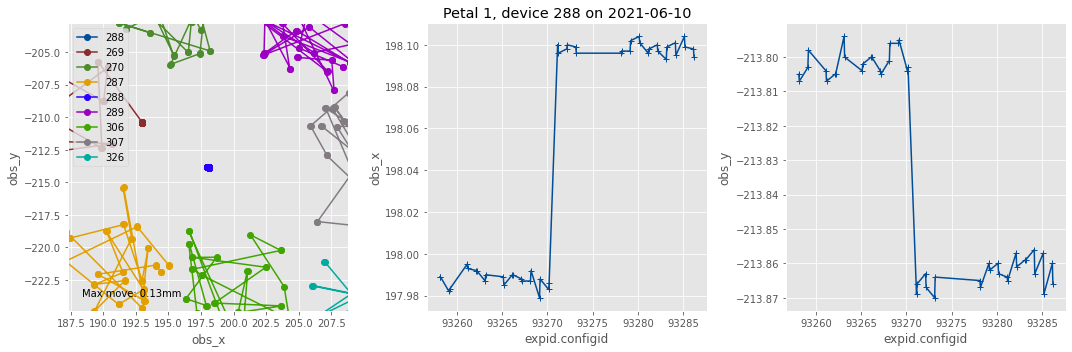

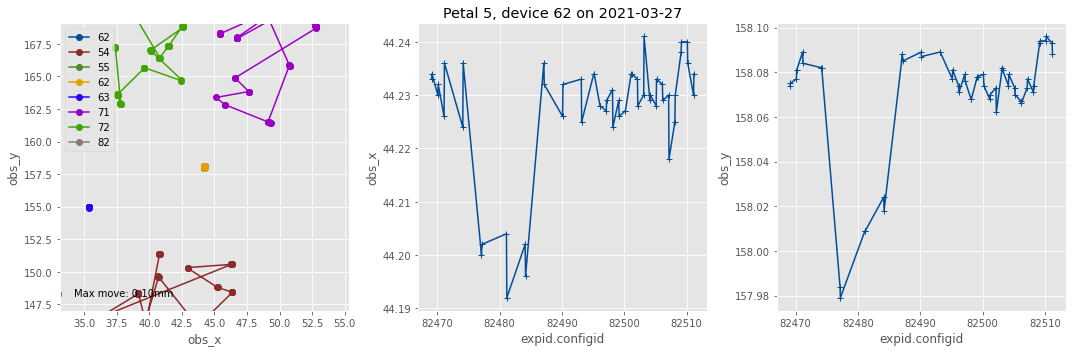

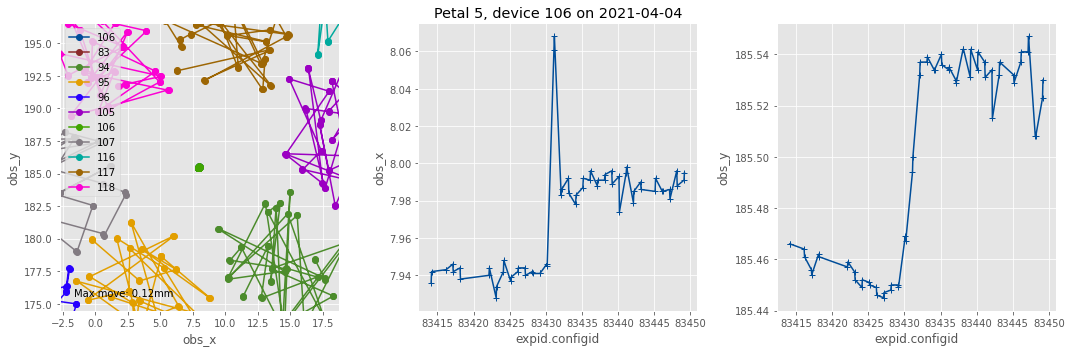

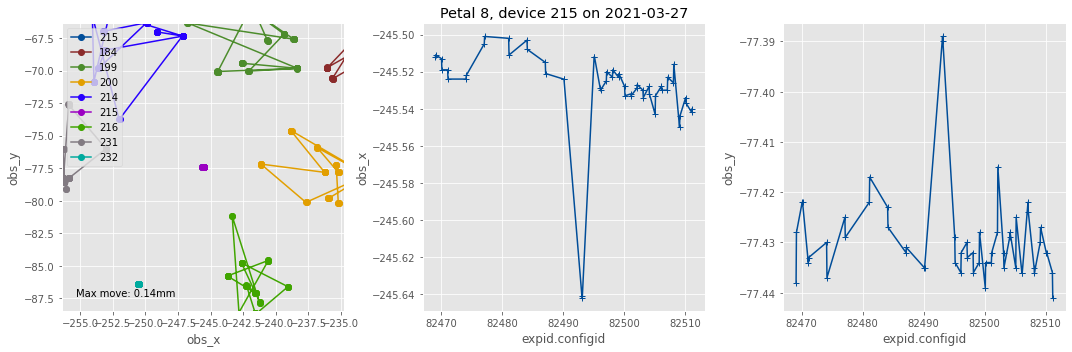

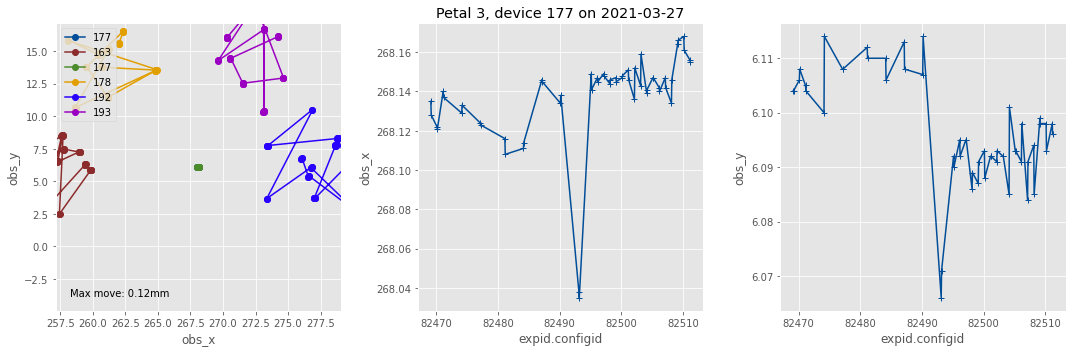

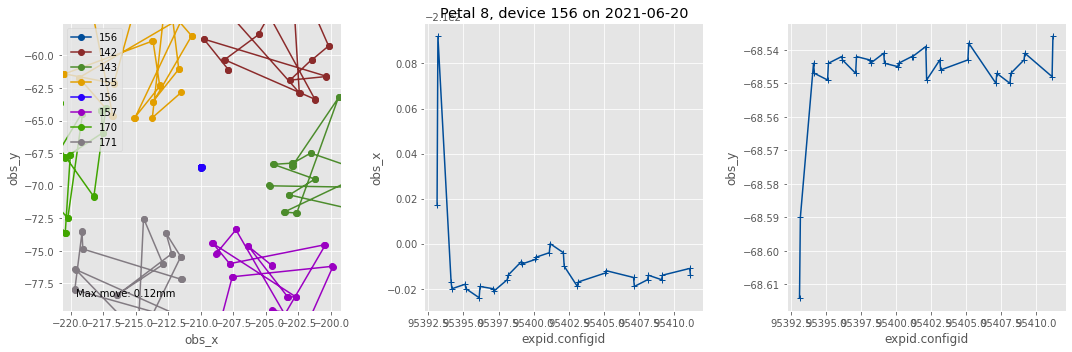

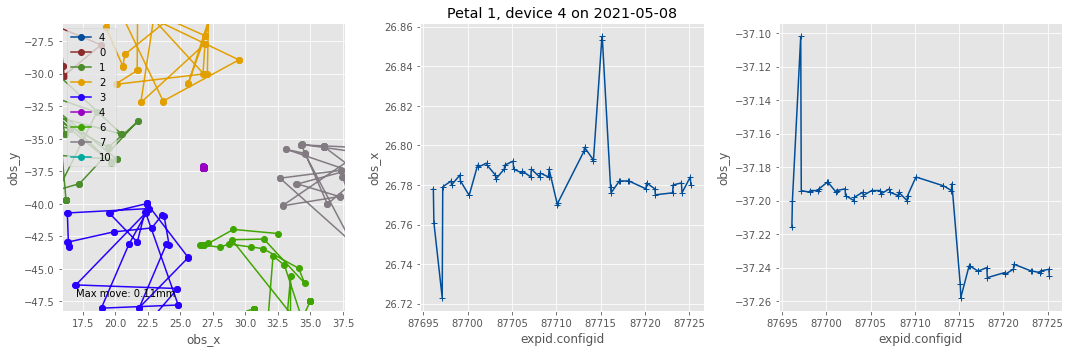

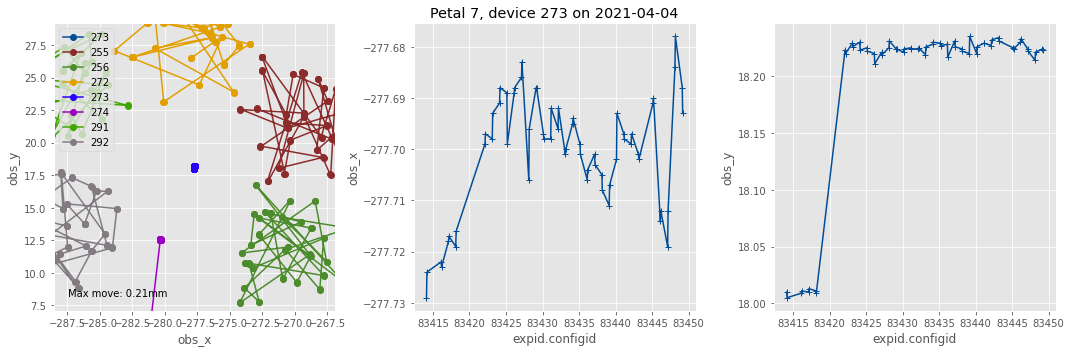

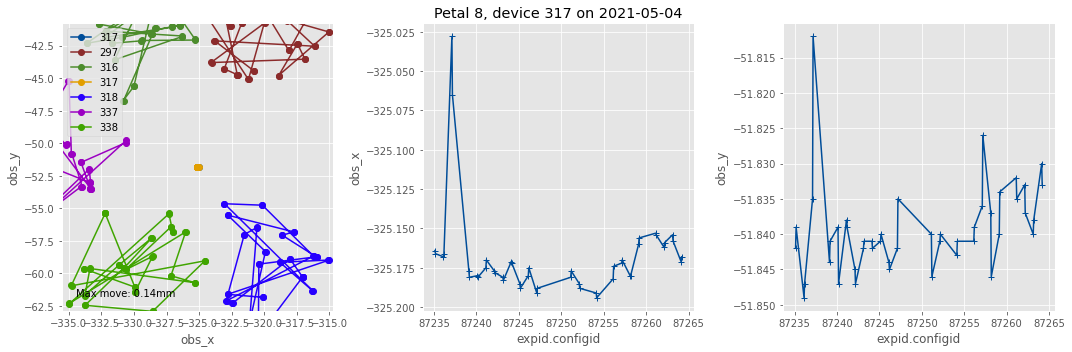

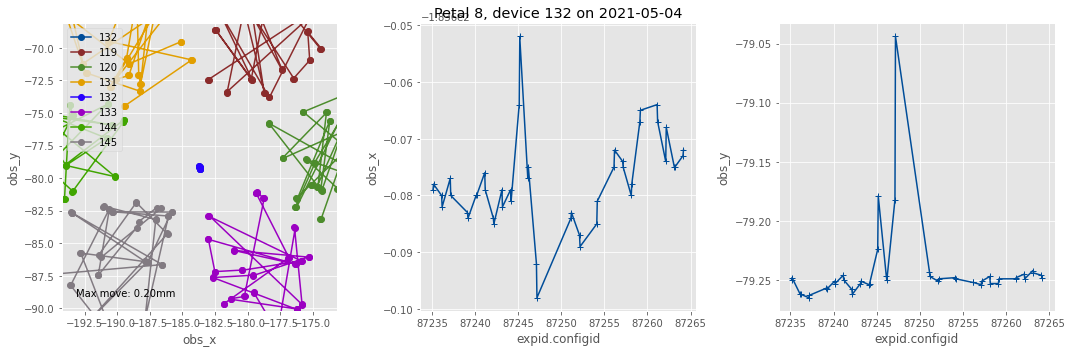

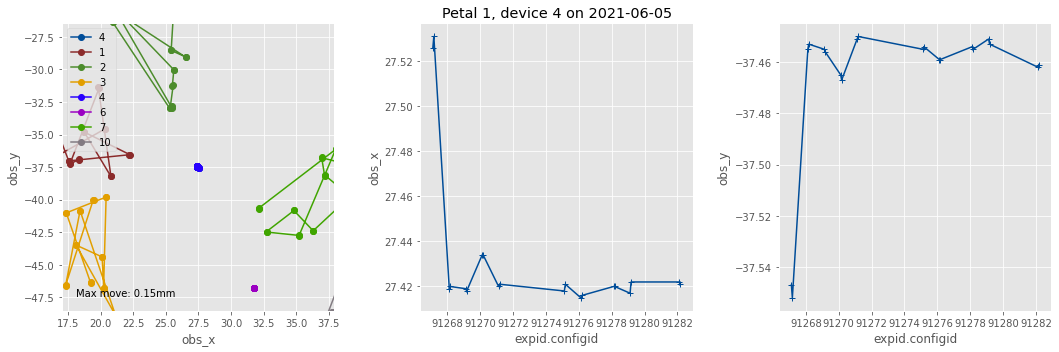

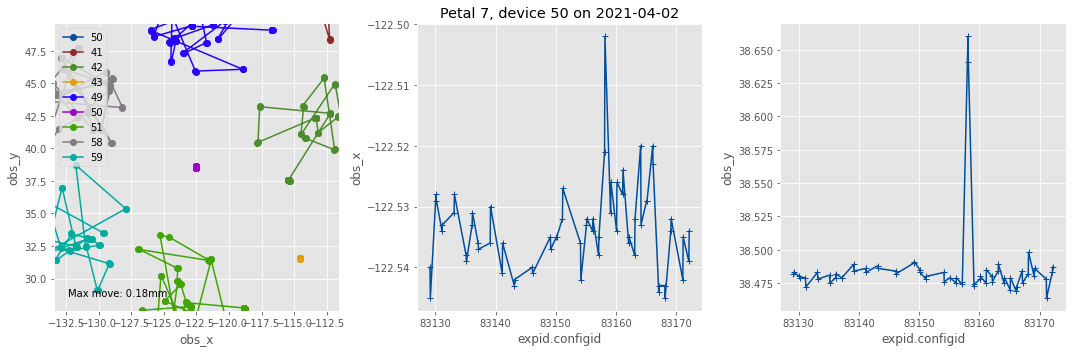

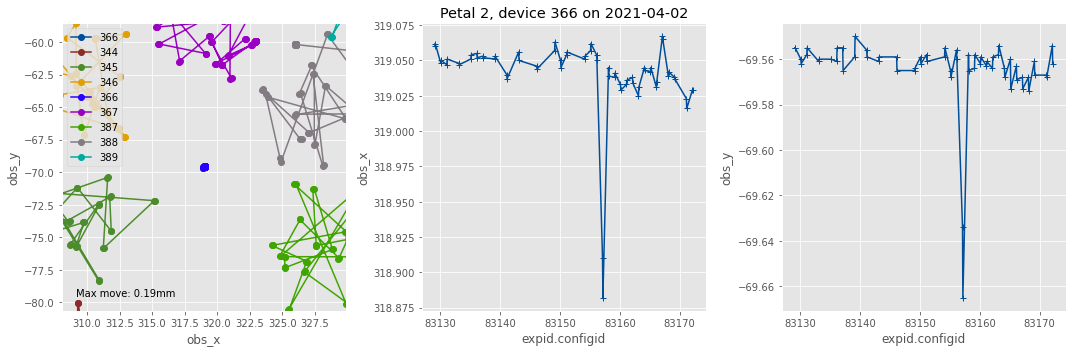

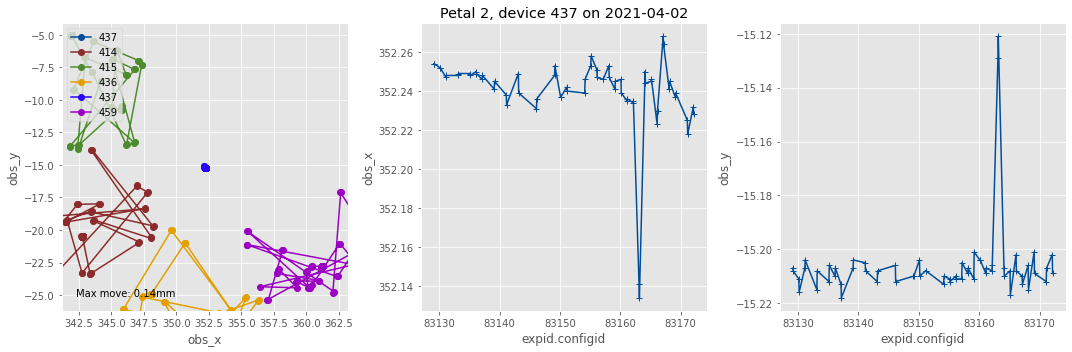

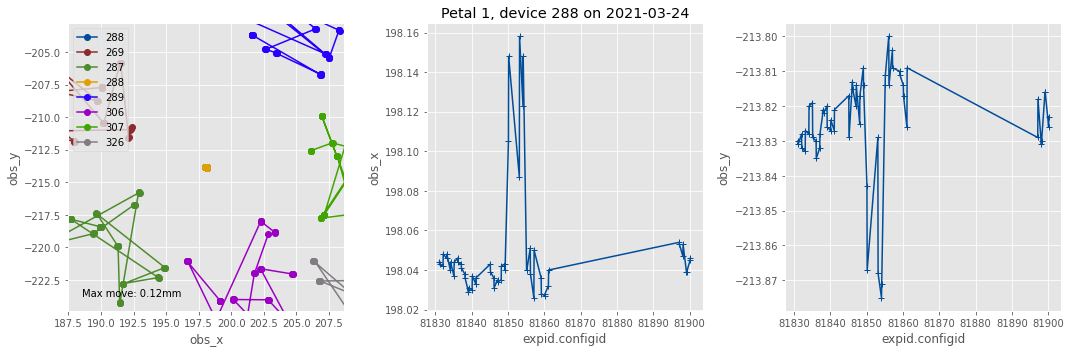

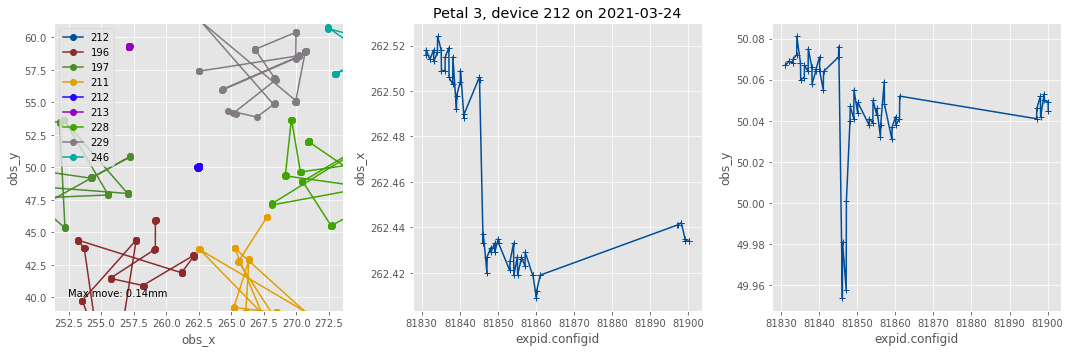

In [30]:
for (night_mjd, petal_loc, device_loc), this_max_diff in max_obs_diff.sample(20, random_state=101).iteritems():
    fig, axes = poscoll.plot_path_with_neighbors(night_mjd, petal_loc, device_loc)